# Modelling Extreme values for the Wind Farm project

This notebook is a brief example of the possibilities offered by the toolbox for modeling extreme values, adapted from the tools provided from the ResourceCode website.

It relies on the `pyextreme` library which get installed with the Resourcecode toolbox. Here we demonstrate 2 examples of univariate modeling as shown in class. For more information, see https://georgebv.github.io/pyextremes/.

# 1. Wave Dynamics

## 1.1 Characterizing the study site mean wave conditions

This notebook covers Part I.A of the wind turbine project: Characterizing the mean wave conditions and seasonal variability at the selected study site. The goal is to analyze long-term hindcast data to understand the typical and seasonal wave climate.

---

### Import Required Libraries




In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyextremes import (
    plot_mean_residual_life,
    plot_parameter_stability, 
    EVA
)
import resourcecode

from resourcecode.eva import (
    censgaussfit,
    get_fitted_models,
    get_gpd_parameters,
    run_simulation,
    huseby,
)
import warnings
warnings.filterwarnings("ignore")

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

---
### Chosen Study Site

**Site:** Bretagne Sud 1
**Coordinates:** $(47.5882, -3.3215)$



In [179]:
client = resourcecode.Client()
# load the resourcecode dataset from Bretagne Sud 1
# find the closest point to the coordinates
point_id, dist_m = resourcecode.data.get_closest_point(latitude=47.5882, longitude=-3.3215)
print(point_id, dist_m)

# get the data from the closest point
data = client.get_dataframe_from_criteria(
    """
{
    "node": 126096,
    "start": 0,
    "end": 99999903600,
    "parameter": ["hs","uwnd","vwnd"]
}
"""
)

126096 238.69



---
### Data Source

The analysis will use long-term (1994-2020) hindcast simulations from the **ResourceCode wave database**.

**Variables to download**:
* Significant wave height ($H_{m0}$)
* Mean wave period ($T_{m02}$)
* Mean wave direction
* Wind velocity
* Current velocity





In [180]:
# lets investigate the dataset
# can we locate our point in the dataset?
# lets add direction, signifcant wave period, and wind speed to the dataset
data["dir"] = resourcecode.utils.zmcomp2metconv(data.uwnd, data.vwnd)[1]
data["Tm02"] = resourcecode.utils.zmcomp2metconv(data.hs, data.dir)[0]
data["wspd"] = resourcecode.utils.zmcomp2metconv(data.uwnd, data.vwnd)[0]
data.head()

,hs,uwnd,vwnd,dir,Tm02,wspd
1994-01-01 00:00:00,3.126,10.2,-6.2,301.293039,301.309255,11.936499
1994-01-01 01:00:00,3.200,9.6,-5.9,301.574191,301.591168,11.268097
1994-01-01 02:00:00,3.242,8.9,-4.8,298.339132,298.356747,10.111874
1994-01-01 03:00:00,3.280,9.2,-4.1,294.020247,294.038542,10.072239
1994-01-01 04:00:00,3.304,9.4,-4.1,293.565396,293.583988,10.255243



---
### 1. Mean Wave Conditions

First, we will load and plot the 26-year time series (1994-2020) for significant wave height, mean wave period, and mean wave direction. We will also calculate the mean value for each variable over the entire time series.





### 1.1 Block Maxima (BM) Method

**Approach:**  
This approach involves dividing the long-term time series of significant wave heights into non-overlapping blocks of equal duration, typically one year.

**Process:**  
The single highest significant wave height (Hₘ₀) is taken from each block (e.g., the annual maximum).

**Distribution:**  
These maximum values are then fitted to a *Generalized Extreme Value (GEV)* distribution.

**Outcome:**  
This model allows you to estimate the wave height corresponding to a specific return period, such as the 1-year or 50-year storm.

In [181]:
# resample the data into 1 year blocks and extract the maximum value from each block by using pyextremes
model = EVA(data.hs)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
    min_last_block=0.9,
)


Lets check the directions of the extreme heights

In [182]:
# lets find the directions of the extremes from the data
data_extreme_directions = data.loc[model.extremes.index, "dir"]
data_extreme_tm02 = data.loc[model.extremes.index, "Tm02"]




In [183]:
model.extremes.head()

date-time
1994-02-03 19:00:00    6.164
1995-09-07 14:00:00    7.448
1996-02-07 16:00:00    6.550
1997-11-09 12:00:00    5.766
1998-01-04 19:00:00    6.416
Name: hs, dtype: float64

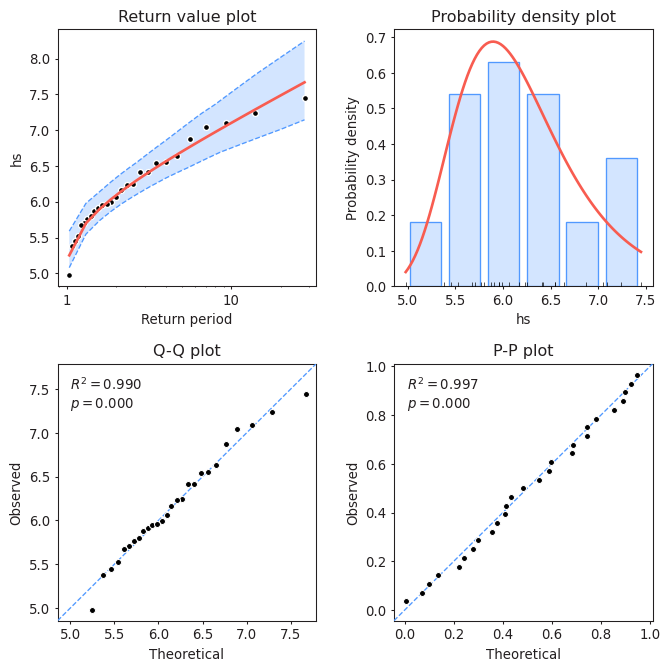

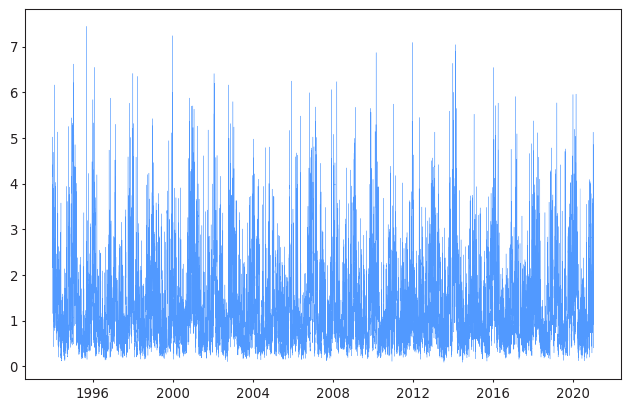

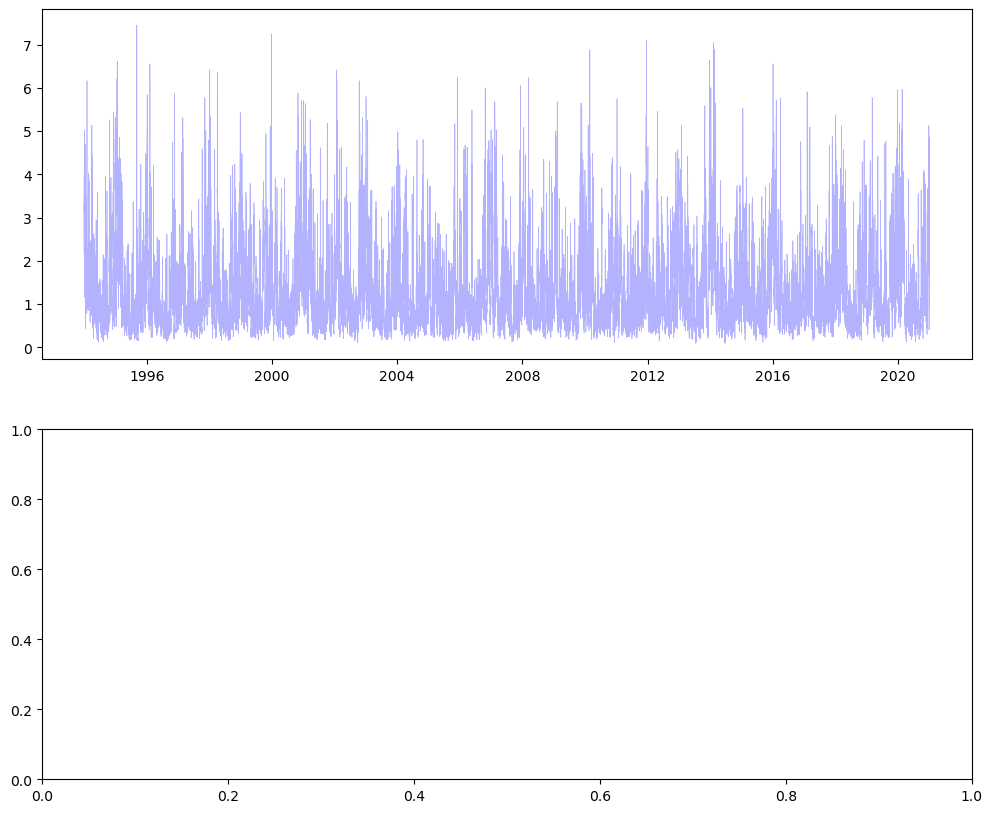

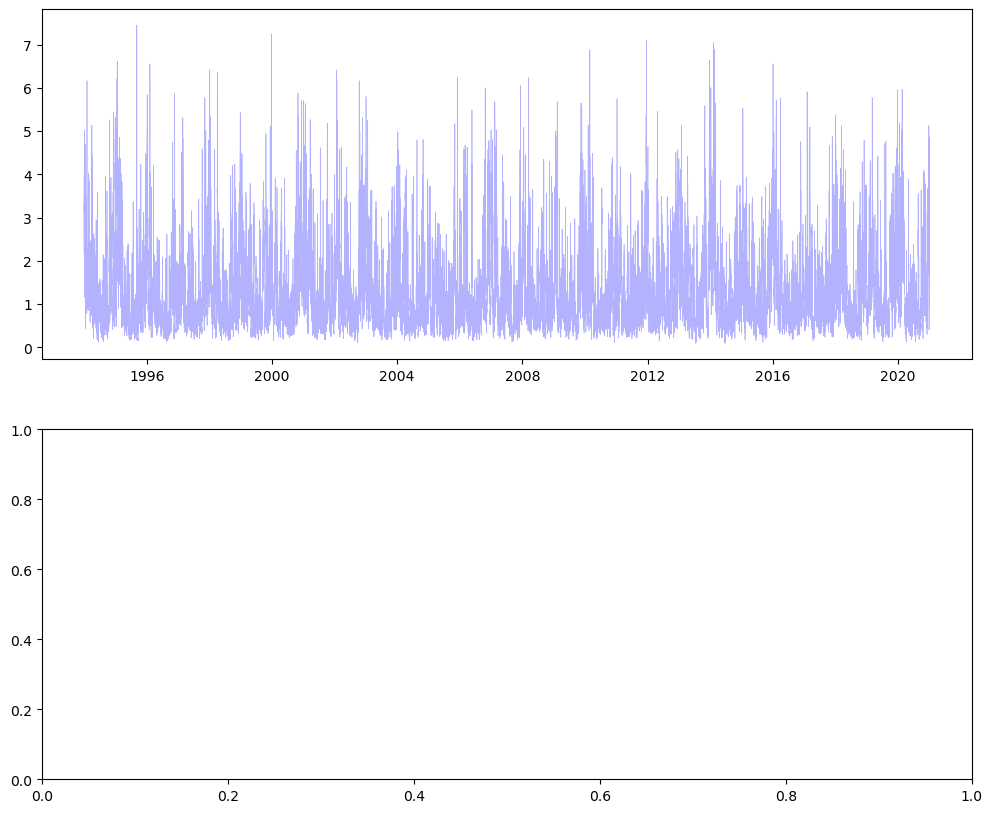

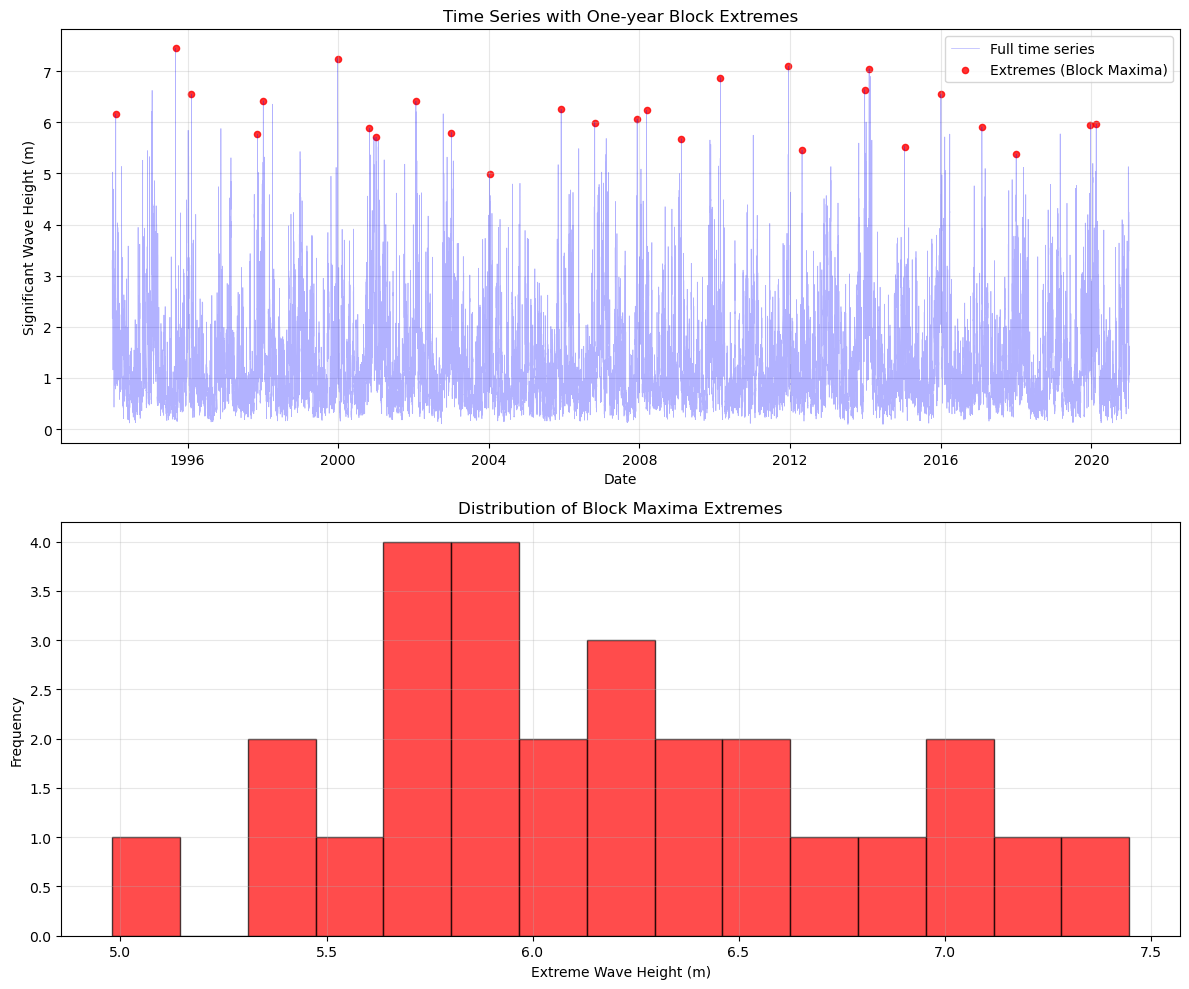

Number of extremes: 27
Mean extreme value: 6.184 m
Maximum extreme value: 7.448 m
Minimum extreme value: 4.980 m
Standard deviation: 0.606 m


In [184]:
# Manual plotting of extremes using matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Time series with extremes highlighted
ax1.plot(data.index, data.hs, 'b-', alpha=0.3, linewidth=0.5, label='Full time series')
ax1.scatter(model.extremes.index, model.extremes.values, color='red', s=20, alpha=0.8, label='Extremes (Block Maxima)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Significant Wave Height (m)')
ax1.set_title('Time Series with One-year Block Extremes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Histogram of extremes
ax2.hist(model.extremes.values, bins=15, alpha=0.7, color='red', edgecolor='black')
ax2.set_xlabel('Extreme Wave Height (m)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Block Maxima Extremes')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics about the extremes
print(f"Number of extremes: {len(model.extremes)}")
print(f"Mean extreme value: {model.extremes.mean():.3f} m")
print(f"Maximum extreme value: {model.extremes.max():.3f} m")
print(f"Minimum extreme value: {model.extremes.min():.3f} m")
print(f"Standard deviation: {model.extremes.std():.3f} m")



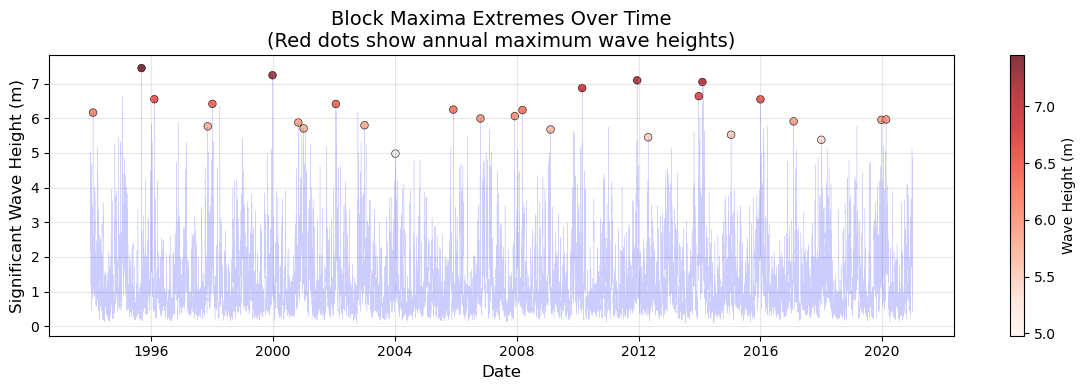

In [185]:
# More detailed manual plotting of extremes
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Plot the full time series
ax.plot(data.index, data.hs, 'b-', alpha=0.2, linewidth=0.3, label='Full time series')

# Highlight extremes with different colors based on magnitude
extremes = model.extremes
colors = plt.cm.Reds(np.linspace(0.3, 1, len(extremes)))
scatter = ax.scatter(extremes.index, extremes.values, c=extremes.values, 
                    cmap='Reds', s=30, alpha=0.8, edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Wave Height (m)')

# Customize the plot
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Significant Wave Height (m)', fontsize=12)
ax.set_title('Block Maxima Extremes Over Time\n(Red dots show annual maximum wave heights)', fontsize=14)
ax.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()


In [186]:
# lets execute GEV fit on the extremes
model.fit_model()


In [187]:
# lets save the diagnostic plot to folder graphs in the current directory   
model.plot_diagnostic(alpha=0.95)
plt.savefig('graphs/diagnostic_plot.png')


In [ ]:
# lets create one concise dataframe with the extremes and the corresponding directions and periods
# Create a DataFrame with extremes and their timestamps
extremes_df = pd.DataFrame({
    'hs': model.extremes.values,
    'timestamp': model.extremes.index
})

# Get corresponding values from original data
extremes_df['dir'] = data.loc[extremes_df.timestamp, 'dir']
extremes_df['wspd'] = data.loc[extremes_df.timestamp, 'wspd']
extremes_df['Tm02'] = data.loc[extremes_df.timestamp, 'Tm02']

# Sort by wave height in descending order
extremes_df = extremes_df.sort_values('hs', ascending=False)

# Display the DataFrame
print("\nExtreme Events Summary:")
print("=" * 80)
print(extremes_df)




**Q: Do any trends in the wave height, period, or direction exist over the 26 year time period? Do you expect there to be changes in the mean conditions during the 30-year lifetime of the wind turbine? If so, why?**


---
### 2. Most Common Wave Conditions

To identify the most common operating conditions, we will create a 2D histogram (scatter diagram) of significant wave height ($H_{m0}$) versus mean wave period ($T_{m02}$). We will also plot a wave rose to identify the most common wave incidence direction(s).









**Q: What is the water depth at this location? Indicate on the histrogram for what wave conditions the waves are considered deep water waves? linear waves?**


---
### 3. Seasonal Variability

Next, we will evaluate temporal variability by calculating and plotting the mean wave height, period, and direction as a function of the month of the year (e.g., mean for January, February, etc.).






**Q: Do you observe any seasonal trends in wave height, period, or direction? If so, why?**



---
### 4. Mean Wind and Current Conditions

We will also evaluate the wind and current conditions by plotting rose diagrams of their respective velocities and directions.


**Q: What are the mean conditions (e.g. velocity and direction)? (if you have time: do you observe any seasonal variability?)**


---
### 5. Comparison to Wave Buoy Measurements

We can validate the ResourceCode hindcast data against observations from a nearby wave buoy, for example, from the Candhis website.






**Q: Comparing the hindcast data from ResourceCode to the observations during the time period with overlapping data, what is the RMSD in the wave height, period, and direction between the observations and simulations?**

---
### Report Submission Note

The results from this analysis (Part I.A) and the extreme wave analysis (Part I.B) will be compiled into a concise report due on 24/10/2025.

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyextremes import (
    plot_mean_residual_life,
    plot_parameter_stability, 
    EVA
)
import resourcecode

from resourcecode.eva import (
    censgaussfit,
    get_fitted_models,
    get_gpd_parameters,
    run_simulation,
    huseby,
)
import warnings
warnings.filterwarnings("ignore")

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

We first load the data from the Bretagne Sud 1 location `126096` (coordinates: $(47.5882, -3.3215)$).

In [189]:
point_id, dist_m = resourcecode.data.get_closest_point(latitude=47.5882, longitude=-3.3215)
print(point_id, dist_m)

126096 238.69


In [190]:
client = resourcecode.Client()
data = client.get_dataframe_from_criteria(
    """
{
    "node": 126096,
    "start": 0,
    "end": 99999903600,
    "parameter": ["hs","uwnd","vwnd"]
}
"""
)

In [191]:
data.head()

,hs,uwnd,vwnd
1994-01-01 00:00:00,3.126,10.2,-6.2
1994-01-01 01:00:00,3.200,9.6,-5.9
1994-01-01 02:00:00,3.242,8.9,-4.8
1994-01-01 03:00:00,3.280,9.2,-4.1
1994-01-01 04:00:00,3.304,9.4,-4.1


From the $u$ and $v$ components of the wind, calculate the wind speed and direction.

In [192]:
data["wspd"], data["wdir"] = resourcecode.utils.zmcomp2metconv(data.uwnd, data.vwnd)

In [193]:
data.head()

,hs,uwnd,vwnd,wspd,wdir
1994-01-01 00:00:00,3.126,10.2,-6.2,11.936499,301.293039
1994-01-01 01:00:00,3.200,9.6,-5.9,11.268097,301.574191
1994-01-01 02:00:00,3.242,8.9,-4.8,10.111874,298.339132
1994-01-01 03:00:00,3.280,9.2,-4.1,10.072239,294.020247
1994-01-01 04:00:00,3.304,9.4,-4.1,10.255243,293.565396


### Modelling univariate time series: Block maxima + GEVD (Generalized Extreme Value Distribution)

We show as an example here a **BM** (block maxima) model fitted to the $H_s$ time series. In this approach, the maximum value is identified within a "block" or fixed period in time, and then a GEVP distribution is fit to the data to estimate the return values.  

The same plot can readily be obtained for the other sea-state parameters.

AttributeError: module 'scipy.stats' has no attribute 'circstats'

In [ ]:
# FIXED VERSION: COMPREHENSIVE SEASONAL ANALYSIS OF EXTREME WAVE HEIGHTS
# All-in-one cell for complete seasonality extraction (with DatetimeIndex fix)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from statsmodels.tsa.stattools import acf

# Extract seasonal information from the extremes - FIXED VERSION
# Ensure we have a proper DataFrame with DatetimeIndex
extremes_df = pd.DataFrame({'hs': model.extremes.values}, index=model.extremes.index)
extremes_df.index = pd.to_datetime(extremes_df.index)  # Ensure it's a DatetimeIndex

extremes_df['month'] = extremes_df.index.month
extremes_df['season'] = extremes_df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})
extremes_df['year'] = extremes_df.index.year

# Calculate monthly statistics
monthly_counts = extremes_df['month'].value_counts().sort_index()
monthly_means = extremes_df.groupby('month')['hs'].mean()
monthly_maxs = extremes_df.groupby('month')['hs'].max()
monthly_std = extremes_df.groupby('month')['hs'].std()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Circular statistics for seasonality
monthly_angles = (extremes_df['month'] - 1) * 2 * np.pi / 12
circular_mean = np.arctan2(np.sin(monthly_angles).sum(), np.cos(monthly_angles).sum())
circular_mean_month = (circular_mean * 12 / (2 * np.pi) + 1) % 12
if circular_mean_month == 0:
    circular_mean_month = 12

R = np.sqrt(np.sin(monthly_angles).sum()**2 + np.cos(monthly_angles).sum()**2) / len(monthly_angles)
circular_variance = 1 - R

# Rayleigh test for uniformity
rayleigh_stat, rayleigh_p = stats.circstats.rayleigh(monthly_angles)

# Create comprehensive plots
fig = plt.figure(figsize=(20, 16))

# Plot 1: Monthly distribution with dual y-axis
ax1 = plt.subplot(3, 3, 1)
bars = ax1.bar(monthly_counts.index, monthly_counts.values, alpha=0.7, color='skyblue', 
               edgecolor='black', label='Count of Extremes')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Extremes', color='blue')
ax1.set_title('Monthly Distribution of Extreme Wave Heights', fontsize=12, fontweight='bold')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.tick_params(axis='y', labelcolor='blue')

# Add mean values as line plot
ax1_twin = ax1.twinx()
ax1_twin.plot(monthly_means.index, monthly_means.values, 'ro-', linewidth=2, markersize=6, 
              color='red', label='Mean Height')
ax1_twin.set_ylabel('Mean Wave Height (m)', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Plot 2: Seasonal box plots
ax2 = plt.subplot(3, 3, 2)
seasonal_data = [extremes_df[extremes_df['season'] == season]['hs'].values 
                 for season in ['Winter', 'Spring', 'Summer', 'Autumn']]

box_plot = ax2.boxplot(seasonal_data, labels=['Winter', 'Spring', 'Summer', 'Autumn'], 
                       patch_artist=True, showfliers=True)
colors = ['lightblue', 'lightgreen', 'orange', 'brown']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Wave Height (m)')
ax2.set_title('Seasonal Distribution of Extreme Wave Heights', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add statistical annotations
for i, season in enumerate(['Winter', 'Spring', 'Summer', 'Autumn']):
    season_data = extremes_df[extremes_df['season'] == season]['hs']
    if len(season_data) > 0:
        ax2.text(i+1, season_data.max() + 0.1, f'n={len(season_data)}', 
                ha='center', va='bottom', fontweight='bold')

# Plot 3: Time series with seasonal coloring
ax3 = plt.subplot(3, 3, 3)
scatter = ax3.scatter(extremes_df.index, extremes_df['hs'], 
                     c=extremes_df['month'], cmap='tab20', s=50, alpha=0.8, edgecolors='black')
ax3.set_xlabel('Year')
ax3.set_ylabel('Wave Height (m)')
ax3.set_title('Extreme Wave Heights Over Time (Colored by Month)', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Month')
ax3.grid(True, alpha=0.3)

# Plot 4: Circular histogram (rose plot)
ax4 = plt.subplot(3, 3, 4, projection='polar')
monthly_counts_polar = monthly_counts.reindex(range(1, 13), fill_value=0)
theta = np.linspace(0, 2*np.pi, 13)[:-1]  # 12 months
width = 2*np.pi/12
bars = ax4.bar(theta, monthly_counts_polar.values, width=width, alpha=0.7, 
               color=plt.cm.viridis(monthly_counts_polar.values / monthly_counts_polar.max()))
ax4.set_theta_zero_location('N')  # January at top
ax4.set_theta_direction(-1)  # Clockwise
ax4.set_xticks(theta)
ax4.set_xticklabels(months)
ax4.set_title('Circular Distribution of Extremes\n(Rose Plot)', fontsize=12, fontweight='bold', pad=20)

# Add circular mean arrow
ax4.arrow(circular_mean, monthly_counts_polar.max() * 0.8, 0, monthly_counts_polar.max() * 0.2, 
          head_width=0.2, head_length=0.1, fc='red', ec='red', linewidth=3)
ax4.text(circular_mean + 0.3, monthly_counts_polar.max() * 0.9, 'Mean', 
         fontsize=10, fontweight='bold', color='red')

# Plot 5: Monthly trend analysis with error bars
ax5 = plt.subplot(3, 3, 5)
ax5.errorbar(monthly_means.index, monthly_means.values, 
             yerr=monthly_std.values, fmt='o-', capsize=5, capthick=2,
             linewidth=2, markersize=8, color='darkblue', alpha=0.8)
ax5.fill_between(monthly_means.index, 
                 monthly_means.values - monthly_std.values,
                 monthly_means.values + monthly_std.values,
                 alpha=0.3, color='blue')
ax5.set_xlabel('Month')
ax5.set_ylabel('Mean Wave Height (m)')
ax5.set_title('Monthly Mean Wave Heights with Error Bars', fontsize=12, fontweight='bold')
ax5.set_xticks(range(1, 13))
ax5.set_xticklabels(months)
ax5.grid(True, alpha=0.3)

# Plot 6: Seasonal intensity heatmap
ax6 = plt.subplot(3, 3, 6)
yearly_monthly_counts = extremes_df.groupby(['year', 'month']).size().unstack(fill_value=0)
yearly_monthly_counts = yearly_monthly_counts.reindex(columns=range(1, 13), fill_value=0)

im = ax6.imshow(yearly_monthly_counts.T, cmap='YlOrRd', aspect='auto', interpolation='nearest')
ax6.set_xlabel('Year')
ax6.set_ylabel('Month')
ax6.set_title('Extreme Events Heatmap\n(Year vs Month)', fontsize=12, fontweight='bold')
ax6.set_yticks(range(12))
ax6.set_yticklabels(months)
ax6.set_xticks(range(0, len(yearly_monthly_counts), max(1, len(yearly_monthly_counts)//10)))
ax6.set_xticklabels(yearly_monthly_counts.index[::max(1, len(yearly_monthly_counts)//10)])

cbar = plt.colorbar(im, ax=ax6)
cbar.set_label('Number of Extremes')

# Plot 7: Monthly autocorrelation analysis
ax7 = plt.subplot(3, 3, 7)
monthly_series = extremes_df.groupby(extremes_df.index.to_period('M'))['hs'].max()
monthly_series = monthly_series.reindex(pd.date_range(monthly_series.index[0].start_time, 
                                                      monthly_series.index[-1].end_time, 
                                                      freq='M'), fill_value=np.nan)

lags = range(1, 13)  # 12 months
autocorr = [monthly_series.autocorr(lag=lag) for lag in lags]

ax7.bar(lags, autocorr, alpha=0.7, color='green', edgecolor='black')
ax7.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax7.axhline(y=0.2, color='red', linestyle='--', alpha=0.7, label='Significance threshold')
ax7.axhline(y=-0.2, color='red', linestyle='--', alpha=0.7)
ax7.set_xlabel('Lag (months)')
ax7.set_ylabel('Autocorrelation')
ax7.set_title('Monthly Autocorrelation of Extreme Heights', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Plot 8: Seasonal statistics summary table
ax8 = plt.subplot(3, 3, 8)
ax8.axis('off')
ax8.set_title('Seasonal Statistics Summary', fontsize=12, fontweight='bold', pad=20)

seasonal_stats = extremes_df.groupby('season')['hs'].agg(['count', 'mean', 'std', 'min', 'max']).round(3)
seasonal_stats = seasonal_stats.reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

table_data = []
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    if season in seasonal_stats.index:
        stats = seasonal_stats.loc[season]
        table_data.append([
            season,
            f"{stats['count']:.0f}",
            f"{stats['mean']:.3f}",
            f"{stats['std']:.3f}",
            f"{stats['min']:.3f}",
            f"{stats['max']:.3f}"
        ])

table = ax8.table(cellText=table_data,
                  colLabels=['Season', 'Count', 'Mean (m)', 'Std (m)', 'Min (m)', 'Max (m)'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Style the table
for i in range(len(table_data) + 1):
    for j in range(6):
        cell = table[(i, j)]
        if i == 0:  # Header
            cell.set_facecolor('#4CAF50')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

# Plot 9: Density plot of extremes by season
ax9 = plt.subplot(3, 3, 9)
for i, season in enumerate(['Winter', 'Spring', 'Summer', 'Autumn']):
    season_data = extremes_df[extremes_df['season'] == season]['hs']
    if len(season_data) > 0:
        x_range = np.linspace(extremes_df['hs'].min()*0.8, extremes_df['hs'].max()*1.2, 1000)
        density = stats.gaussian_kde(season_data)
        y_density = density(x_range)
        ax9.plot(x_range, y_density, linewidth=2, label=f'{season} (n={len(season_data)})', alpha=0.8)

ax9.set_xlabel('Wave Height (m)')
ax9.set_ylabel('Density')
ax9.set_title('Seasonal Density Distributions', fontsize=12, fontweight='bold')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comprehensive analysis results
print("="*80)
print("COMPREHENSIVE SEASONAL ANALYSIS OF EXTREME WAVE HEIGHTS")
print("="*80)

print(f"\nDATA SUMMARY:")
print(f"Total number of extremes: {len(extremes_df)}")
print(f"Date range: {extremes_df.index.min().strftime('%Y-%m-%d')} to {extremes_df.index.max().strftime('%Y-%m-%d')}")

print(f"\nCIRCULAR STATISTICS:")
print(f"Circular mean month: {months[int(circular_mean_month)-1]} (month {circular_mean_month:.1f})")
print(f"Circular variance: {circular_variance:.4f}")
print(f"Rayleigh test p-value: {rayleigh_p:.6f}")
if rayleigh_p < 0.05:
    print("→ Significant seasonal clustering (p < 0.05)")
else:
    print("→ No significant seasonal clustering (p ≥ 0.05)")

print(f"\nSEASONAL PATTERN SUMMARY:")
print(f"Most extreme-prone month: {months[monthly_counts.idxmax()-1]} ({monthly_counts.max()} events)")
print(f"Least extreme-prone month: {months[monthly_counts.idxmin()-1]} ({monthly_counts.min()} events)")
print(f"Season with most extremes: {extremes_df['season'].value_counts().index[0]}")
print(f"Season with highest mean: {extremes_df.groupby('season')['hs'].mean().idxmax()}")
print(f"Circular concentration: {R:.3f} (1.0 = perfect clustering, 0.0 = uniform)")

print(f"\nDETAILED SEASONAL STATISTICS:")
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    season_data = extremes_df[extremes_df['season'] == season]['hs']
    if len(season_data) > 0:
        print(f"\n{season.upper()}:")
        print(f"  Number of extremes: {len(season_data)}")
        print(f"  Mean height: {season_data.mean():.3f} m")
        print(f"  Standard deviation: {season_data.std():.3f} m")
        print(f"  Minimum: {season_data.min():.3f} m")
        print(f"  Maximum: {season_data.max():.3f} m")
        print(f"  Percentage of total extremes: {len(season_data)/len(extremes_df)*100:.1f}%")
    else:
        print(f"\n{season.upper()}: No extremes recorded")

# Calculate seasonal risk assessment
winter_risk = len(extremes_df[extremes_df['season'] == 'Winter']) / len(extremes_df) * 100
summer_risk = len(extremes_df[extremes_df['season'] == 'Summer']) / len(extremes_df) * 100
spring_risk = len(extremes_df[extremes_df['season'] == 'Spring']) / len(extremes_df) * 100
autumn_risk = len(extremes_df[extremes_df['season'] == 'Autumn']) / len(extremes_df) * 100

print(f"\nRISK ASSESSMENT:")
print(f"Winter risk: {winter_risk:.1f}% of all extremes")
print(f"Spring risk: {spring_risk:.1f}% of all extremes")
print(f"Summer risk: {summer_risk:.1f}% of all extremes")
print(f"Autumn risk: {autumn_risk:.1f}% of all extremes")

if summer_risk > 0:
    print(f"Risk ratio (Winter/Summer): {winter_risk/summer_risk:.2f}")
if spring_risk > 0:
    print(f"Risk ratio (Winter/Spring): {winter_risk/spring_risk:.2f}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE - All seasonal patterns extracted and visualized!")
print("="*80)


After loading the data, apply the block method approach with a block size of 1 year (365.2425 days), where each data block must be at least 90% full to take into account in the analysis.

In [ ]:
model = EVA(data.hs)
model.get_extremes(method="BM", block_size="365.2425D", min_last_block=0.9)

In [ ]:
model.extremes.head()

date-time
1994-02-03 19:00:00    6.164
1995-09-07 14:00:00    7.448
1996-02-07 16:00:00    6.550
1997-11-09 12:00:00    5.766
1998-01-04 19:00:00    6.416
Name: hs, dtype: float64

In [ ]:
model.plot_extremes()

(<Figure size 768x480 with 1 Axes>, <Axes: xlabel='date-time', ylabel='hs'>)

NameError: name 'gev_params' is not defined

In [ ]:
model.fit_model()

The parameter alpha specifies the confidence limits (default = 0.95).

In [ ]:
model.plot_diagnostic(alpha=0.95)

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='hs'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='hs', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

The parameter n_samples indicates the number of bootstrap samples used to estimate the confidence bounds.

In [ ]:
summary = model.get_summary(
        return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
        alpha=0.95,
        n_samples=1000,
    )
print(summary)

               return value  lower ci   upper ci
return period                                   
1.0                    -inf       NaN        NaN
2.0                6.091837  5.880252   6.337905
5.0                6.698079  6.377176   7.008616
10.0               7.099463  6.679026   7.480492
25.0               7.606614  7.032831   8.078853
50.0               7.982847  7.297642   8.538098
100.0              8.356302  7.550735   8.991648
250.0              8.848017  7.897909   9.592006
500.0              9.219300  8.153206  10.042572
1000.0             9.590315  8.406153  10.503731


### Modelling univariate time series: Peaks over threshold (POT) + GPD (Generalized Pareto Distribution)

We show as example here a **POT** (peaks over threshold) model fitted to the $H_s$ time series. This analysis first finds values over a specified threshold and then declusters these values using a predefined clustering distance, and finally finds the maximum value within each cluster. 

The same plot can readily be obtained for the other sea-state parameters.

We first can have a look at the quality of the fitted model, and to the corresponding return levels as a function of the selected wave height threshold. The parameters r and alpha specify the minimum time distance (duration) between adjacent clusters and the confidence limits (default = 0.95), respectively.

The shape and modified scale parameters define the Generalized Pareto Distribution, and they depend on the threshold value, but should be stable within a range of valid thresholds (e.g. less than ~3m here).

In [ ]:
plot_parameter_stability(ts=data.hs,r='72H',alpha=.95);

/opt/anaconda3/lib/python3.12/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  r = pd.to_timedelta(r)
/opt/anaconda3/lib/python3.12/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  r = pd.to_timedelta(r)
/opt/anaconda3/lib/python3.12/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  r = pd.to_timedelta(r)
/opt/anaconda3/lib/python3.12/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  r = pd.to_timedelta(r)
/opt/anaconda3/lib/python3.12/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' i

The mean residual life plots the average excess value over a given threshold, and it should be approcimately linear above the threshold for which the GPD model is valid (e.g. <~3m)

In [ ]:
plot_mean_residual_life(data.hs);

The analysis is completed for both Hs and the wind speed, specifying a window of 72 hours and a quantile of 0.98 for determining the threshold to specify.

In [ ]:
quant=0.98
models = get_fitted_models(data[["hs","wspd"]],quantile=quant,r="72H")

In [ ]:
models

[                           Univariate Extreme Value Analysis                            
                                       Source Data                                       
 ----------------------------------------------------------------------------------------
 Data label:                            hs      Size:                             236,688
 Start:                       January 1994      End:                        December 2020
                                      Extreme Values                                     
 ----------------------------------------------------------------------------------------
 Count:                                189      Extraction method:                    POT
 Type:                                high      Threshold:                          3.828
                                          Model                                          
 ----------------------------------------------------------------------------------------
 Model:   

In [ ]:
models[0].plot_diagnostic(alpha=0.95);

In [ ]:
models[1].plot_diagnostic(alpha=0.95);

In [ ]:
pd.DataFrame(get_gpd_parameters(models),columns=["mu","sigma","xi"],index=["Hs","Wspd"])

,mu,sigma,xi
Hs,3.828000,1.325214,-0.305804
Wspd,13.730623,2.680247,-0.122354


In [ ]:
summary_Hs = models[0].get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000,
)
summary_Wspd = models[1].get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000,
)
print(summary_Hs)
print(summary_Wspd)

               return value  lower ci  upper ci
return period                                  
1.0                5.771451  5.563888  5.974929
2.0                6.227978  5.998292  6.440704
5.0                6.700485  6.425624  6.920771
10.0               6.979559  6.661929  7.231055
25.0               7.268400  6.872789  7.623867
50.0               7.438997  6.989069  7.884644
100.0              7.577008  7.070664  8.108391
               return value   lower ci   upper ci
return period                                    
1.0               19.436488  18.755340  20.002866
2.0               20.753737  19.606105  21.560918
5.0               22.332120  20.494920  23.446532
10.0              23.413918  21.056192  24.822461
25.0              24.710173  21.574967  26.468856
50.0              25.598606  21.882426  27.749457
100.0             26.414799  22.122460  29.012675
